In [19]:
# -*- coding: utf-8 -*-
import cv2
import numpy as np

import copy
import pylab as plt

import os
import shutil
import imageio
gif_images = []

%matplotlib inline

In [4]:
def not_exist_mkdir( output_path ):
    if( not os.path.exists(output_path) ):
        os.mkdir( output_path )


In [5]:
def sub_color(src, K):

    # 次元数を1落とす
    Z = src.reshape((-1,3))

    # float32型に変換
    Z = np.float32(Z)

    # 基準の定義
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

    # K-means法で減色
    ret, label, center = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # UINT8に変換
    center = np.uint8(center)

    res = center[label.flatten()]

    # 配列の次元数と入力画像と同じに戻す
    return res.reshape((src.shape))


In [6]:
def show_histogram(im):
    if im.ndim == 2:
        # グレースケール
        plt.hist(im.lavel(), 256, range=(0, 255), fc='k')
        plt.show()

    elif im.ndim == 3:
        # カラー
        fig = plt.figure()
        fig.add_subplot(311)
        plt.hist(im[:,:,0].ravel(), 256, range=(0, 255), fc='b')
        plt.xlim(0,255)
        fig.add_subplot(312)
        plt.hist(im[:,:,1].ravel(), 256, range=(0, 255), fc='g')
        plt.xlim(0,255)
        fig.add_subplot(313)
        plt.hist(im[:,:,2].ravel(), 256, range=(0, 255), fc='r')
        plt.xlim(0,255)
        plt.show()


In [36]:
def segmentation(inputimg):
    shutil.rmtree("./segment_pic")
    not_exist_mkdir("./segment_pic")
    
    segmentator = cv2.ximgproc.segmentation.createGraphSegmentation(sigma=0.5, k=200, min_size=1000)
    #src = cv2.imread(path)
    src = inputimg
    src = cv2.resize(src,(640,480) )
    segment = segmentator.processImage(src)

    # グレースケールへの変換(1chになる)
    tmp_gray=cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
    gray_image = cv2.merge((tmp_gray,tmp_gray,tmp_gray))

    mask = segment.reshape(list(segment.shape) + [1]).repeat(3, axis=2)
    masked = np.ma.masked_array(src, fill_value=0)
    for i in range(np.max(segment)):
        print("{0}/{1} process done".format(i,np.max(segment)-1))
        masked.mask = mask != i
        y, x = np.where(segment == i)
        top, bottom, left, right = min(y), max(y), min(x), max(x)
        dst = masked.filled()[top : bottom + 1, left : right + 1]  ## masked.maskで定義したマスク部分に0をかぶせる
        cv2.imwrite('./segment_pic/segment_{num}.jpg'.format(num=i), dst)

        #get gif
        gif_imagesrc = np.where(masked.mask,gray_image,src)
        gif_images.append(gif_imagesrc)
        
    #save to gif
    imageio.mimsave('segment.gif', gif_images,duration=0.2)

    segment = segment*(int(255/segment.max())-1)
    cv2.imwrite('./segment_pic/segment_all.jpg', segment)
    return segment

In [8]:
# 入力画像とスクリーントーン画像を取得
img = cv2.imread("./lightdesign/02.jpg") 
img = cv2.resize(img,(640,480) )
# ノイズ除去
dst = cv2.fastNlMeansDenoisingColored(img,None,10,15,7,21)

In [9]:
# 減色処理(三値化)
dst = sub_color(dst, K=40)

In [37]:
segpic=segmentation(img)

0/34 process done
1/34 process done
2/34 process done
3/34 process done
4/34 process done
5/34 process done
6/34 process done
7/34 process done
8/34 process done
9/34 process done
10/34 process done
11/34 process done
12/34 process done
13/34 process done
14/34 process done
15/34 process done
16/34 process done
17/34 process done
18/34 process done
19/34 process done
20/34 process done
21/34 process done
22/34 process done
23/34 process done
24/34 process done
25/34 process done
26/34 process done
27/34 process done
28/34 process done
29/34 process done
30/34 process done
31/34 process done
32/34 process done
33/34 process done
34/34 process done


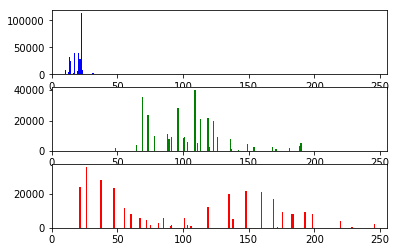

In [11]:
#hsv
hsv = cv2.cvtColor(dst, cv2.COLOR_BGR2HSV)
Hchanel,Schanel,Vchanel=cv2.split(hsv)
hsv_transed=copy.deepcopy(hsv)
hsv_transed[:,:,1] = 255
hsv_transed[:,:,2] = 255#int(np.mean(Vchanel))
show_histogram(hsv)

In [28]:
# 結果を出力
cv2.imwrite("kmeans_output.jpg", dst)

cv2.imshow('stack',np.hstack((img,dst)))
cv2.imshow('hsv_transed',cv2.cvtColor(hsv_transed, cv2.COLOR_HSV2BGR))
cv2.imshow('h',Hchanel)
cv2.imshow('s',Schanel)
cv2.imshow('v',Vchanel)

cv2.waitKey(0)
cv2.destroyAllWindows()

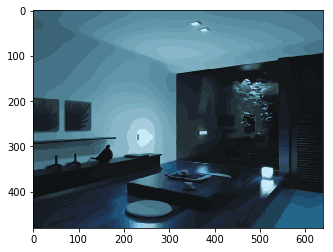

In [118]:
plt.imshow(dst)

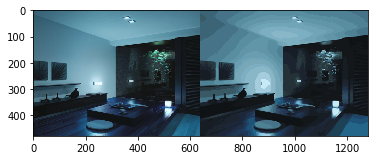

In [42]:
plt.imshow(np.hstack((img,dst)))

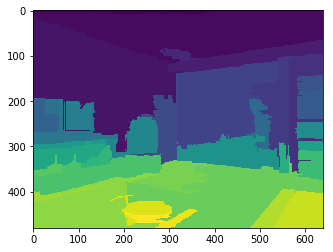

In [38]:
plt.imshow(segpic)

In [98]:
#分割された領域内のS,V を平均化する
segmentator = cv2.ximgproc.segmentation.createGraphSegmentation(sigma=0.5, k=200, min_size=1000)
#src = cv2.imread(path)
src = img
src = cv2.resize(src,(640,480) )
segment = segmentator.processImage(src)

# HSVへの変換(3chになる)
hsv = cv2.cvtColor(src, cv2.COLOR_BGR2HSV)
Hchanel,Schanel,Vchanel=cv2.split(hsv)

mask = segment.reshape(list(segment.shape) + [1]).repeat(3, axis=2)
masked = np.ma.masked_array(src, fill_value=0)

In [114]:
Schanelnew=Schanel
Vchanelnew=Vchanel
Hchanelnew=Hchanel
for i in range(np.max(segment)):
    #print("{0}/{1} process done".format(i,np.max(segment)-1))
    #masked.mask = mask != i
    
    #平均を求める
    Hmeanval=np.mean(np.where(segment==i,Hchanelnew,0))
    #平均値で上書き
    Hchanelnew=np.where(segment==i,Hmeanval,Hchanelnew)
    Hchanelnew=Hchanelnew.astype('uint8')
    
    #平均を求める
    Smeanval=np.mean(np.where(segment==i,Schanelnew,0))
    #平均値で上書き
    Schanelnew=np.where(segment==i,Smeanval,Schanelnew)
    Schanelnew=Schanelnew.astype('uint8')
    
    #平均を求める
    Vmeanval=np.mean(np.where(segment==i,Vchanelnew,0))
    #平均値で上書き
    Vchanelnew=np.where(segment==i,Vmeanval,Vchanelnew)
    Vchanelnew=Vchanelnew.astype('uint8')
    """
    y, x = np.where(segment == i)
    top, bottom, left, right = min(y), max(y), min(x), max(x)
    dst = masked.filled()[top : bottom + 1, left : right + 1]  ## masked.maskで定義したマスク部分に0をかぶせる
    cv2.imwrite('./segment_pic/segment_{num}.jpg'.format(num=i), dst)
    """

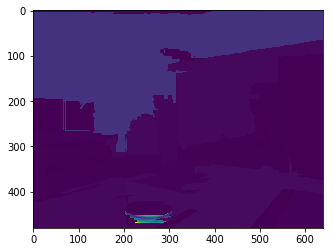

In [100]:
plt.imshow(Vchanelnew)

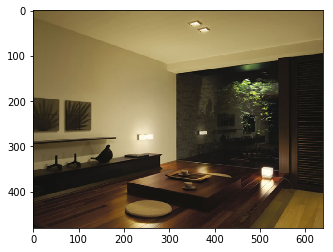

In [119]:
hsvnew=cv2.merge((Hchanel,Schanel,Vchanel))
rgb = cv2.cvtColor(hsvnew, cv2.COLOR_HSV2RGB)
plt.imshow(rgb)

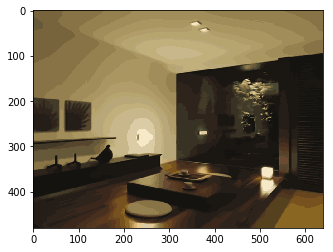

In [122]:
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_RGB2BGR))